## Feature Engineering and Model training

This notebook is for performing feature engineering and come up with all the pre-processing techniques before converting it into python module scripts.

Also, we will do the model training and select the best model for inference.

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)


In [2]:
# Laoding the dataset

df = pd.read_csv(r"Visa_dataset.csv")

# Print shape of dataset
print(df.shape)

(25480, 12)


In [3]:
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


### Data Pre-Processing

Checking the missing values

In [4]:
df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

> We don't have any missing values in the dataset. But also cross-verify the numeric variable which could have zero as a missing value.

Handling Duplicated values


In [5]:
df.duplicated().sum()

0

> There is no duplicate records in the dataset.

In [6]:
# dropping the case_id column which is not useful 

df.drop('case_id', axis=1, inplace=True)

In [7]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


### Feature Extraction


To get the Age of Applicant's company

In [8]:
# example code to get the current year

from datetime import date 

today_date = date.today()
current_year = today_date.year
print(current_year)

2025


In [9]:
# creating new feature 

df["company_age"] = current_year - df["yr_of_estab"]

df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


> we can drop the year of establishment column as it is not an important feature to the model

In [10]:
df.drop("yr_of_estab", axis=1, inplace=True)

Splitting the features into numerical and categorical features

In [11]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != "O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

# printing the features
print(f"There are {len(numerical_features)} numerical features in the dataset: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features in the dataset: {categorical_features}")

There are 3 numerical features in the dataset: ['no_of_employees', 'prevailing_wage', 'company_age']
There are 8 categorical features in the dataset: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


> All our numerical features are continuous numerical as the unique values are greater than 25.

#### Splitting the dataframe into features and target variable

In [12]:
X = df.drop("case_status", axis=1)
y = df["case_status"]

In [13]:
y.value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

Encoding the target variable

Certified = 1 and Denied = 0

In [14]:
y = np.where(y=="Certified", 1, 0)
y

array([0, 1, 0, ..., 1, 1, 1])

#### Feature Transformation 

We have numerical features which are skewed and contains outliers. 

What is Skewness ?

Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero.


Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

We will use Power Transformation implementation from Scikit Learn package which uses Box Cox Transform and Yeo-Johnson transform.


In [15]:
# Checking skewness

X[numerical_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

* Positively skewed - No of employees and company Age feature are positively skewed.
* We should handle outliers and again check the skewness.

Applying Power Transformation to treat the outliers 

In [16]:
from sklearn.preprocessing import PowerTransformer 

pt = PowerTransformer(method="yeo-johnson")
transform_features = ["no_of_employees", "company_age"]
tranformed_features = pt.fit_transform(X[transform_features])
tranformed_features

array([[ 1.51729976, -0.95555058],
       [ 0.03091211, -0.4670008 ],
       [ 2.88507606, -1.07836334],
       ...,
       [-0.41388512,  1.55020883],
       [-0.11194883,  1.68473893],
       [ 0.21874168,  1.02763813]])

In [17]:
X_copy = pd.DataFrame(tranformed_features, columns=transform_features)
X_copy.head()

,no_of_employees,company_age
0,1.517300,-0.955551
1,0.030912,-0.467001
2,2.885076,-1.078363
3,-1.343550,1.630914
4,-0.432287,-0.738126


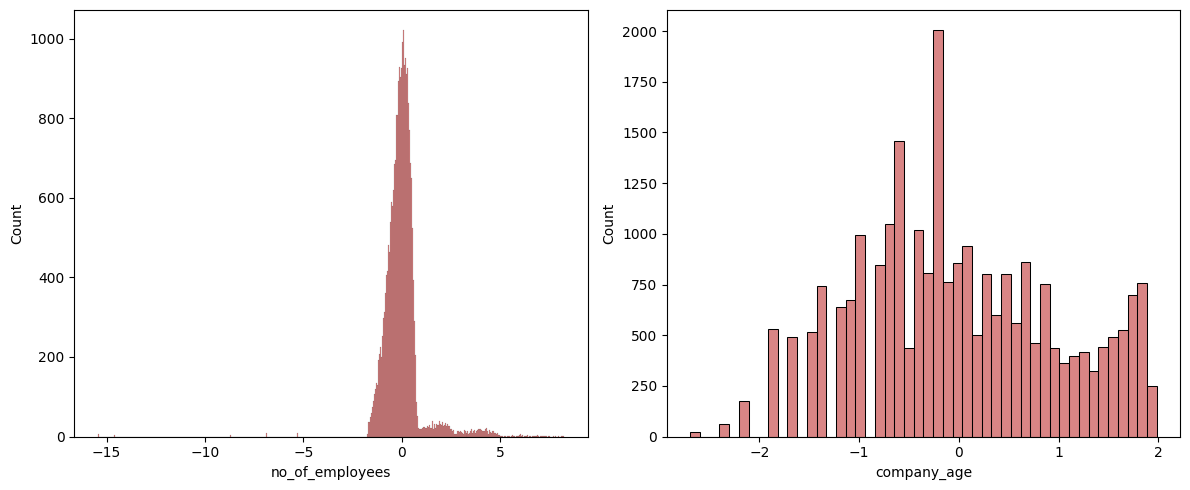

In [18]:
# checking the distribution of transformed features 
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [19]:
# checking skewness again for transformed features 

X_copy.skew(axis=0, skipna=True)

no_of_employees    0.399339
company_age        0.112260
dtype: float64

> Now the skewness is reduced much further than un-transformed features

### Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**

Ordinal encoding is used here as label encoder is supported for column transformer.
Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler**

Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**

Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

In [20]:
numerical_features

['no_of_employees', 'prevailing_wage', 'company_age']

Preprocessing using Sklearn Column Transformer Pipeline

In [21]:
# creating features for applying each of the transformations and applying it

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ord_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
one_hot_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

numeric_transformer = StandardScaler()
one_hot_transformer = OneHotEncoder()
ord_transformer = OrdinalEncoder()

# to treat the outliers / skewness
transform_pipe = Pipeline(
    steps=[('transformer', PowerTransformer(method="yeo-johnson"))]
)

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", one_hot_transformer, one_hot_columns),
        ("OrdinalEncoder", ord_transformer, ord_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, numerical_features)
    ]
)



In [22]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

> Here we have all the data in a numerical format.

#### Splitting the dataset into train and test 

Splitting the dataset into train and test where tarin set will be 80% of the full dataset and test set is 20% used to validate the model.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(20384, 24) (5096, 24)
(20384,) (5096,)


#### Training Machine Learning Models

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
# function to return evaluation metrics of the ML model 

def evaluate_metrics(true_values, pred_values):
    acc = accuracy_score(true_values, pred_values)
    f1 = f1_score(true_values, pred_values)
    precision = precision_score(true_values, pred_values)
    recall = recall_score(true_values, pred_values)
    roc_auc = roc_auc_score(true_values, pred_values)

    return acc, f1, precision, recall, roc_auc

In [26]:
# creating model list

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC()

}

In [33]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    
    models_list = []
    accuracy_list = []
    f1_score = []
    
    for i in range(len(list(models))):

        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision,                            \
        model_train_recall, model_train_roc_auc_score = evaluate_metrics(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision,                              \
        model_test_recall, model_test_roc_auc_score = evaluate_metrics(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_roc_auc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_roc_auc_score))
        f1_score.append(model_test_roc_auc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, f1_score)), columns=['Model Name', 'f1_score']).sort_values(by=['f1_score'], ascending=False)
        
    return report

In [34]:
# calling above function to train ML models and get the back metrics report

baseline_models_report = evaluate_models(X_train, X_test, y_train, y_test, models)
baseline_models_report

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 0.9999
- Recall: 1.0000
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.7282
- F1 score: 0.8072
- Precision: 0.7664
- Recall: 0.8527
- Roc Auc Score: 0.6656


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.6674
- F1 score: 0.7511
- Precision: 0.7501
- Recall: 0.7521
- Roc Auc Score: 0.6247


Logistic Regression
Model performance for Training set
- Accuracy: 0.7064
- F1 score: 0.8065
- Precision: 0.7204
- Recall: 0.9161
- Roc Auc Score: 0.6003
----------------------------------
Model performance for Test set
- Accuracy: 0.7055
- F1 score: 0.8067
- Precision: 0.7177
- Recall: 0.9209
- Roc Auc Score: 0.5970


K-Neighbors Classifier
Model performance for Trai

,Model Name,f1_score
5,CatBoosting Classifier,0.690614
4,XGBClassifier,0.676629
0,Random Forest,0.665578
6,Support Vector Classifier,0.651496
3,K-Neighbors Classifier,0.639954
1,Decision Tree,0.624738
2,Logistic Regression,0.597031


* CatBoost and XGBoost are the top performing baseline models for the dataset
* Try hyper parameter tuning to check if performance improves or we can go ahead with XG Boost classifier for the dataset.

#### Hyper Parameter Tuning

considering tuning hyper paramters for two models which are Random Forest and XGBoost models using randomized Search CV

In [35]:
# defining params for models

#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

In [36]:
# making models list 

random_cv_models = [
    ("XGBoost", XGBClassifier(), xgboost_params),
    ("RandomForest", RandomForestClassifier(), rf_params)
]


In [37]:
# Invoking tuning of the models 

from sklearn.model_selection import RandomizedSearchCV

model_param = {}

for name, model, params in random_cv_models:

    tuned_model = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=30,
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    tuned_model.fit(X_train, y_train)

    # saving the best params with default metric 
    model_param[name] = tuned_model.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 3, 'max_depth': 3}
---------------- Best Params for RandomForest -------------------
{'n_estimators': 50, 'max_features': None, 'max_depth': 10}


In [39]:
# evaluate the tuned models 

best_models = {
    "Random Forest": RandomForestClassifier(**model_param["RandomForest"]),
    "XGBoost": XGBClassifier(**model_param["XGBoost"])
}

tuned_model_metrics = evaluate_models(X_train, X_test, y_train, y_test, models=best_models)
tuned_model_metrics

Random Forest
Model performance for Training set
- Accuracy: 0.7817
- F1 score: 0.8450
- Precision: 0.8038
- Recall: 0.8907
- Roc Auc Score: 0.7266
----------------------------------
Model performance for Test set
- Accuracy: 0.7514
- F1 score: 0.8242
- Precision: 0.7802
- Recall: 0.8736
- Roc Auc Score: 0.6899


XGBoost
Model performance for Training set
- Accuracy: 0.7568
- F1 score: 0.8274
- Precision: 0.7866
- Recall: 0.8726
- Roc Auc Score: 0.6982
----------------------------------
Model performance for Test set
- Accuracy: 0.7533
- F1 score: 0.8252
- Precision: 0.7827
- Recall: 0.8727
- Roc Auc Score: 0.6933




,Model Name,f1_score
1,XGBoost,0.693274
0,Random Forest,0.689881


> `XGBoost Classifier` is the best model among all other models.

#### Running best model 

In [40]:
best_model = XGBClassifier(**model_param['XGBoost'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL XGBoost'")
print("Accuracy Score value: {:.4f}".format(score))
print(cr)

FINAL MODEL XGBoost'
Accuracy Score value: 0.7533
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      1695
           1       0.78      0.87      0.83      3401

    accuracy                           0.75      5096
   macro avg       0.73      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



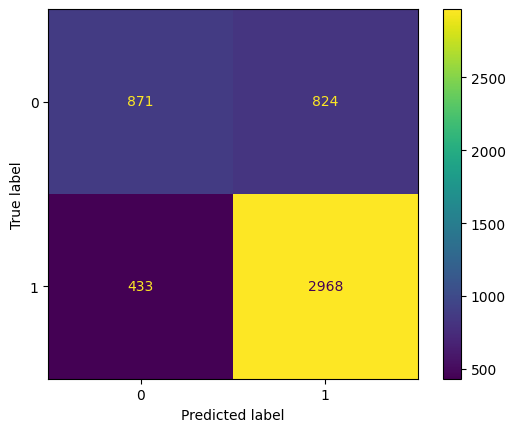

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

XGBoost Classifier is so far best model for our use case. We can use oversampling technique to increase minority classes for better performance of the model.